In [1]:
# ## 1. Load and Preprocess Burglary Data

import multiprocessing as mp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pmdarima import auto_arima

# Load data and aggregate to ward-monthly counts
burglary = pd.read_csv('data/residential_burglary.csv', parse_dates=['Month'])

# Combine 'Year' and 'Month' into a single datetime column
burglary ["Month"] = pd.to_datetime(burglary ["Year"].astype(str) + "-" + burglary ["Month"].astype(str), format="%Y-%m")

burglary_monthly = burglary.groupby(["Ward Code", "Month"]).size().reset_index(name="Count")

burglary_monthly


C:\Users\gusta\AppData\Local\Temp\ipykernel_41472\2008626871.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  burglary = pd.read_csv('data/residential_burglary.csv', parse_dates=['Month'])


,Ward Code,Month,Count
0,E05009317,2013-12-01,8
1,E05009317,2014-01-01,23
2,E05009317,2014-02-01,12
3,E05009317,2014-03-01,11
4,E05009317,2014-04-01,21
...,...,...,...
89633,E05014119,2024-10-01,1
89634,E05014119,2024-11-01,2
89635,E05014119,2024-12-01,4
89636,E05014119,2025-01-01,3


In [2]:
# ## 2. SARIMA Forecasting for All Wards

import warnings

warnings.filterwarnings("ignore")

def analyze_ward(ward_code, ward_df, test_months=14):
    """Analyze a single ward's SARIMA performance"""
    try:
        # Filter wards with sufficient history
        if len(ward_df) < test_months * 2:
            return None

        # Split data
        train = ward_df.iloc[:-test_months]
        test = ward_df.iloc[-test_months:]

        # Auto-fit SARIMA
        model = auto_arima(train['Count'],
                           seasonal=True, m=12,
                           suppress_warnings=True,
                           stepwise=True,
                           error_action='ignore')

        # Generate predictions
        preds = model.predict(n_periods=test_months)

        # Calculate residuals
        residuals = np.subtract(test['Count'].to_numpy(), preds)

        print(f"{ward_code} Completed")

        return {
            'ward_code': ward_code,
            'train_size': len(train),
            'test_size': len(test),
            'residuals': residuals,
            'predicted': preds,
            'actual': test['Count'].values,
            'model_order': str(model.order),
            'model_seasonal_order': str(model.seasonal_order)
        }
    except Exception as e:
        print(f"Error processing {ward_df['Ward Code'].iloc[0]}: {str(e)}")
        return None

# Process all wards
results = []
for ward_code, group in burglary_monthly.groupby('Ward Code'):
    analysis = analyze_ward(ward_code, group)
    if analysis:
        results.append(analysis)


# with mp.Pool(processes=mp.cpu_count()) as pool:
#     args = [(ward_code, group) for ward_code, group in burglary_monthly.groupby('Ward Code')]
#     results = pool.map(analyze_ward, args)

# Remove None results
results = [res for res in results if res is not None]

print(f"\nSuccessfully processed {len(results)} wards with sufficient data")

warnings.filterwarnings("default")


E05009317 Completed
E05009318 Completed
E05009319 Completed
E05009320 Completed
E05009321 Completed
E05009322 Completed
E05009323 Completed
E05009324 Completed
E05009325 Completed
E05009326 Completed
E05009327 Completed
E05009328 Completed
E05009329 Completed
E05009330 Completed
E05009331 Completed
E05009332 Completed
E05009333 Completed
E05009334 Completed
E05009335 Completed
E05009336 Completed
E05009367 Completed
E05009368 Completed
E05009369 Completed
E05009370 Completed
E05009371 Completed
E05009372 Completed
E05009373 Completed
E05009374 Completed
E05009375 Completed
E05009376 Completed
E05009377 Completed
E05009378 Completed
E05009379 Completed
E05009380 Completed
E05009381 Completed
E05009382 Completed
E05009383 Completed
E05009384 Completed
E05009385 Completed
E05009386 Completed
E05009387 Completed
E05009388 Completed
E05009389 Completed
E05009390 Completed
E05009391 Completed
E05009392 Completed
E05009393 Completed
E05009394 Completed
E05009395 Completed
E05009396 Completed



Residual Analysis Results:
Average residual (Actual - Predicted): -0.70
Positive residuals: 36.8%
Negative residuals: 63.2%


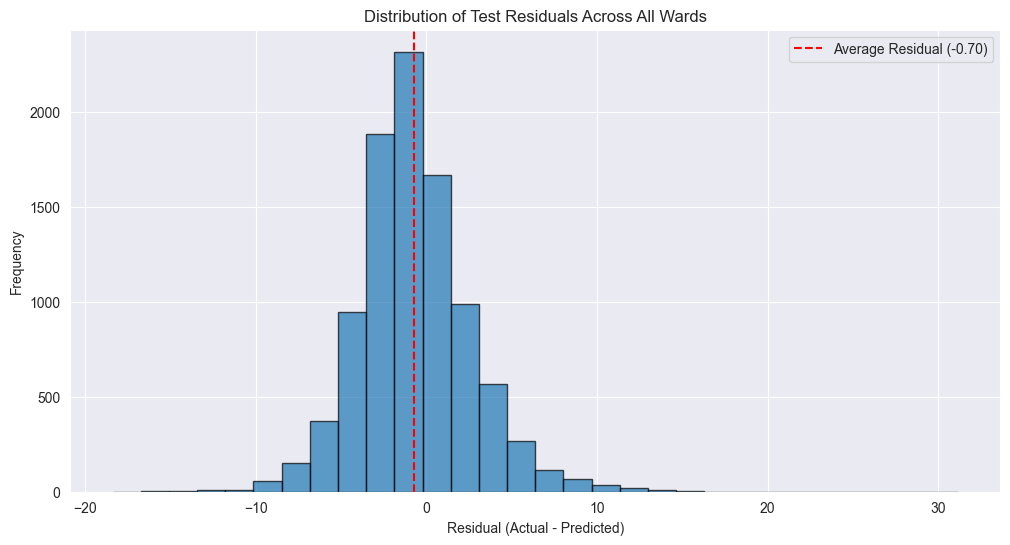

In [3]:
# ## 3. Residual Analysis

# Combine all residuals
all_residuals = []
positive_count = 0
total_residuals = 0

for result in results:
    residuals = result['residuals']
    all_residuals.extend(residuals)
    positive_count += np.sum(residuals > 0)
    total_residuals += len(residuals)

# Calculate statistics
avg_residual = np.mean(all_residuals)
positive_percent = (positive_count / total_residuals) * 100
negative_percent = 100 - positive_percent

print("\nResidual Analysis Results:")
print(f"Average residual (Actual - Predicted): {avg_residual:.2f}")
print(f"Positive residuals: {positive_percent:.1f}%")
print(f"Negative residuals: {negative_percent:.1f}%")

# Visualize distribution
plt.figure(figsize=(12, 6))
plt.hist(all_residuals, bins=30, edgecolor='k', alpha=0.7)
plt.axvline(avg_residual, color='r', linestyle='--',
            label=f'Average Residual ({avg_residual:.2f})')
plt.title('Distribution of Test Residuals Across All Wards')
plt.xlabel('Residual (Actual - Predicted)')
plt.ylabel('Frequency')
plt.legend()
plt.show()



Top 5 Wards with Largest Over-prediction (Negative Residuals):
     ward_code  avg_residual  positive_percent  total_residuals
156  E05013503    -10.317391          0.000000               14
333  E05013680     -6.163651          0.000000               14
23   E05009370     -5.908928          0.000000               14
163  E05013510     -5.592286          7.142857               14
459  E05013806     -5.421624         35.714286               14

Top 5 Wards with Largest Under-prediction (Positive Residuals):
     ward_code  avg_residual  positive_percent  total_residuals
461  E05013808      5.838853         64.285714               14
166  E05013513      5.304852         85.714286               14
71   E05011107      3.723832         71.428571               14
66   E05011102      3.369426         64.285714               14
99   E05011234      3.289332         92.857143               14


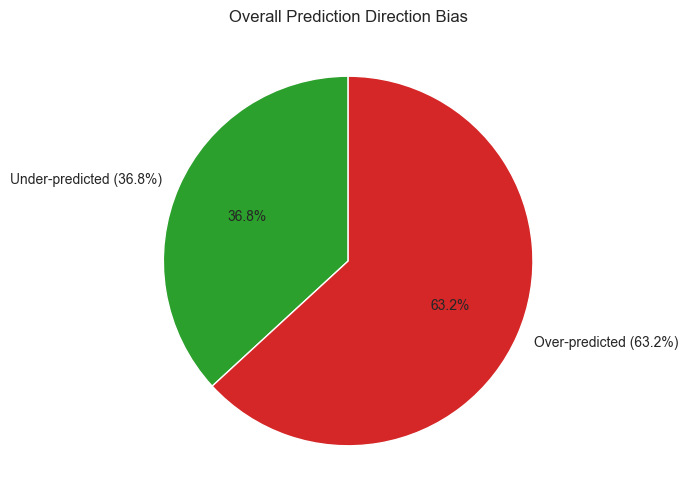

In [4]:
# ## 4. Ward-level Residual Statistics

# Calculate per-ward averages
ward_stats = []
for result in results:
    ward_residuals = result['residuals']
    ward_stats.append({
        'ward_code': result['ward_code'],
        'avg_residual': np.mean(ward_residuals),
        'positive_percent': np.mean(ward_residuals > 0) * 100,
        'total_residuals': len(ward_residuals)
    })

ward_stats_df = pd.DataFrame(ward_stats)

print("\nTop 5 Wards with Largest Over-prediction (Negative Residuals):")
print(ward_stats_df.sort_values('avg_residual').head())

print("\nTop 5 Wards with Largest Under-prediction (Positive Residuals):")
print(ward_stats_df.sort_values('avg_residual', ascending=False).head())

# Visualize residual signs distribution
plt.figure(figsize=(8, 6))
plt.pie([positive_percent, negative_percent],
        labels=[f'Under-predicted ({positive_percent:.1f}%)',
                f'Over-predicted ({negative_percent:.1f}%)'],
        autopct='%1.1f%%',
        startangle=90,
        colors=['#2ca02c', '#d62728'])
plt.title('Overall Prediction Direction Bias')
plt.show()

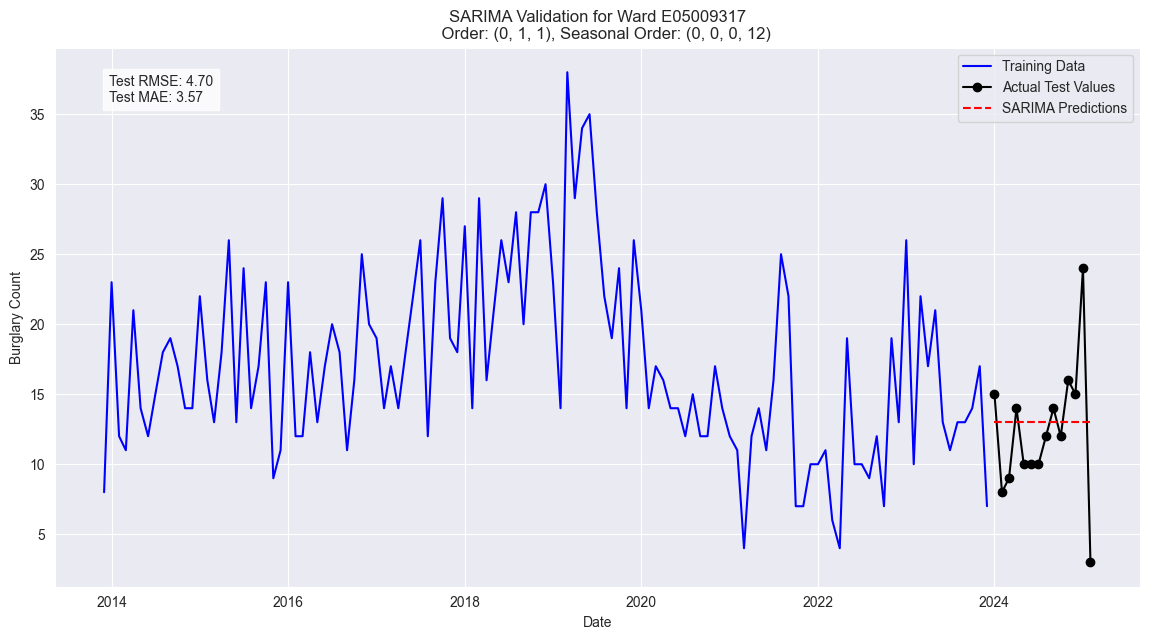


--------------------------------------------------
Residual Statistics for Ward E05009317:
Average Residual: -0.71
Residual Range: [-10.00, 11.00]
Positive Residuals: 42.9%


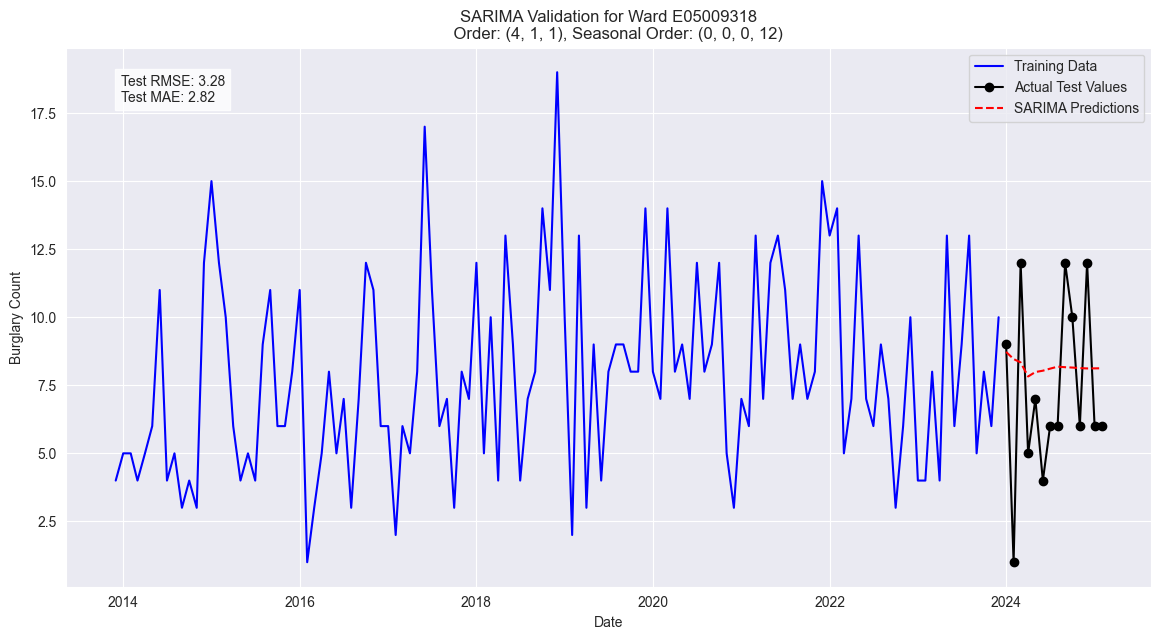


--------------------------------------------------
Residual Statistics for Ward E05009318:
Average Residual: -0.89
Residual Range: [-7.46, 3.88]
Positive Residuals: 35.7%


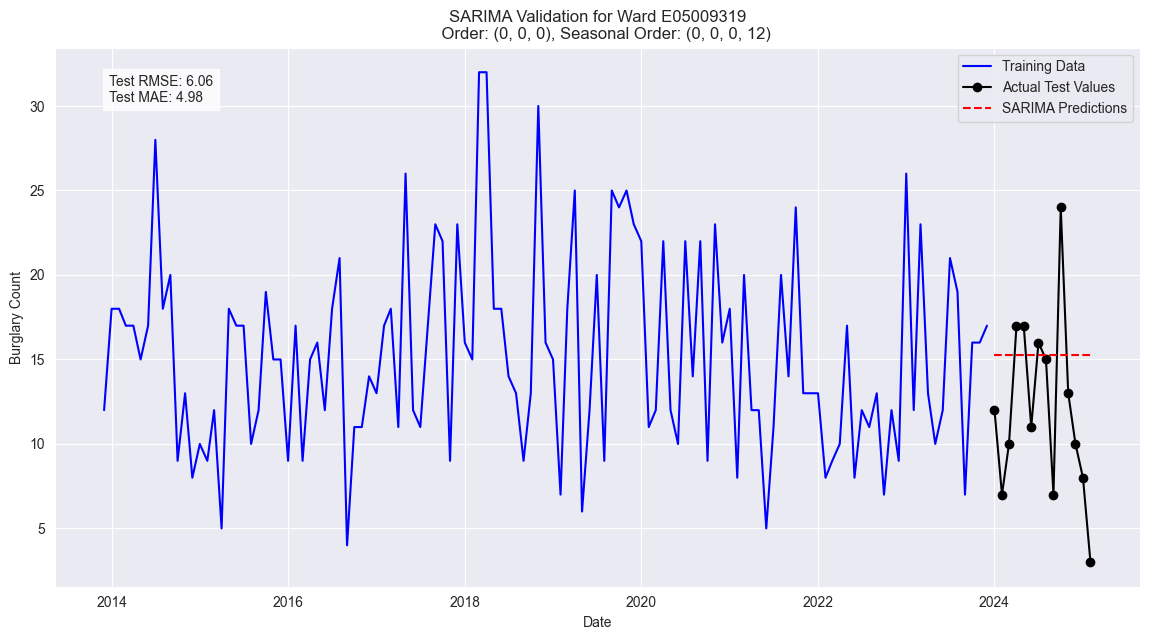


--------------------------------------------------
Residual Statistics for Ward E05009319:
Average Residual: -3.14
Residual Range: [-12.28, 8.72]
Positive Residuals: 28.6%


In [5]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def plot_sarima_validation(result):
    """Plot training data, actual test values and predictions for a single ward"""
    plt.figure(figsize=(14, 7))

    # Extract data
    ward_code = result['ward_code']
    train_dates = burglary_monthly[burglary_monthly['Ward Code'] == ward_code]['Month'].iloc[:-14]
    train_counts = burglary_monthly[burglary_monthly['Ward Code'] == ward_code]['Count'].iloc[:-14]
    test_dates = burglary_monthly[burglary_monthly['Ward Code'] == ward_code]['Month'].iloc[-14:]

    # Create plots
    plt.plot(train_dates, train_counts, 'b-', label='Training Data')
    plt.plot(test_dates, result['actual'], 'ko-', label='Actual Test Values')
    plt.plot(test_dates, result['predicted'], 'r--', label='SARIMA Predictions')

    # Formatting
    plt.title(f'''SARIMA Validation for Ward {ward_code}
    Order: {result['model_order']}, Seasonal Order: {result['model_seasonal_order']}''')
    plt.xlabel('Date')
    plt.ylabel('Burglary Count')
    plt.legend()
    plt.grid(True)

    # Add metrics
    rmse = np.sqrt(mean_squared_error(result['actual'], result['predicted']))
    mae = mean_absolute_error(result['actual'], result['predicted'])
    plt.text(0.05, 0.95,
            f'Test RMSE: {rmse:.2f}\nTest MAE: {mae:.2f}',
            transform=plt.gca().transAxes,
            verticalalignment='top',
            bbox=dict(facecolor='white', alpha=0.8))

    plt.show()

# Plot first 3 wards as examples
for i, result in enumerate(results[:3]):
    plot_sarima_validation(result)
    print(f"\n{'-'*50}\nResidual Statistics for Ward {result['ward_code']}:")
    print(f"Average Residual: {np.mean(result['residuals']):.2f}")
    print(f"Residual Range: [{np.min(result['residuals']):.2f}, {np.max(result['residuals']):.2f}]")
    print(f"Positive Residuals: {np.sum(result['residuals'] > 0)/len(result['residuals']):.1%}")
